# Summary
- Analysis of fine-tuned models

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname
import torch
import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from ipywidgets import FloatSlider, interactive
import sys
sys.path.append('..')
from var import fname2mname, network2pair, network_sort_key

In [2]:
# loading in them all made my machine run out of memory
method_l = [
     "maxcorr", 
     "mincorr", 
     "maxlinreg", 
     "minlinreg", 
    "cca", 
    "lincka", 
    # "rbfcka",
]

In [3]:
# Set `res_d`, `network_l`, `num_neurons_d`
base = "/data/sls/temp/belinkov/contextual-corr-analysis/repr_fine_results4_"
res_fname = {method : base + method for method in 
                method_l}

res_d = {}
for method in method_l:
    with open(res_fname[method], 'rb') as f:
        res_d[method] = pickle.load(f)

network_l = [network for network in res_d["cca"]["corrs"]]
network_l = sorted(network_l, key=network_sort_key)

num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(next(iter(res_d["cca"]["corrs"][network].values()))) # god this is a hack

In [4]:
network_l

['bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_2',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_4',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_5',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_6',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_7',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_8',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11',
 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12',
 'bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0',
 'bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_1',
 'bert_base_cased-ptb_pos_dev_qnli_include_embedding

# MaxCorr, MinCorr, MaxLinReg, MinLinReg

### Sorts

In [5]:
rk_methods = {"maxcorr", "mincorr", "maxlinreg", "minlinreg"}

In [6]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = res_d[method]["neuron_sort"][network]

In [7]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [8]:
for network in network_l:
    print(network)
    # print(rk_df_d[network])
    print(spearman_d[network])

bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0
           minlinreg   mincorr   maxcorr  maxlinreg
minlinreg   1.000000  0.278761  0.394246   0.461015
mincorr     0.278761  1.000000  0.102642   0.131333
maxcorr     0.394246  0.102642  1.000000   0.786421
maxlinreg   0.461015  0.131333  0.786421   1.000000
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1
           minlinreg   mincorr   maxcorr  maxlinreg
minlinreg   1.000000  0.364858  0.117047   0.116570
mincorr     0.364858  1.000000 -0.106539  -0.101160
maxcorr     0.117047 -0.106539  1.000000   0.941126
maxlinreg   0.116570 -0.101160  0.941126   1.000000
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_2
           minlinreg   mincorr   maxcorr  maxlinreg
minlinreg   1.000000  0.342309  0.097493   0.154233
mincorr     0.342309  1.000000 -0.139686  -0.128575
maxcorr     0.097493 -0.139686  1.000000   0.968529
maxlinreg   0.154233 -0.128575  0.968529   1.000000
bert_base_cased-ptb_pos_dev_mnli_include_em

### Distributions

In [9]:
for network in network_l:
    print("\n\n" + network + ":")
    for method in rk_methods:
        print("\n" + method)
        if method == "maxlinreg" or method == "minlinreg": 
            corr_df = pd.DataFrame(res_d[method]['pred_power'][network])
        else:
            corr_df = pd.DataFrame(res_d[method]['corrs'][network])
        
        print("\nmaxcounts")
        print(corr_df.idxmax(axis=1).value_counts())
        
        print("\nmincounts")
        print(corr_df.idxmin(axis=1).value_counts())
        
        print("\ncorr_df_pctl")
        corr_df_pctl = pd.DataFrame()
        corr_df_pctl["max"] = corr_df.max(axis=1)
        corr_df_pctl["min"] = corr_df.min(axis=1)
        corr_df_pctl["med"] = corr_df.median(axis=1)
        print(corr_df_pctl.rank().corr()) # spearman
        
#         corr_df.plot()
#         plt.xlabel("neuron (sorted order)")
#         plt.ylabel("correlation")
#         plt.show()
        
#         plt.hist(corr_ar.ravel(), bins=100)
#         plt.xlabel("correlation")
#         plt.ylabel("count")
#         plt.show()



bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0:

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0     326
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    286
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0       83
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        73
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.461020  0.428868
min  0.461020  1.000000  0.699912
med  0.428868  0.699912  1.000000

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    744
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      16
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        5
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         3
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    745
bert_

          max       min       med
max  1.000000 -0.132792  0.946472
min -0.132792  1.000000 -0.125616
med  0.946472 -0.125616  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3      715
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_5       34
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4     18
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_4       1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    678
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     90
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.132792  0.946472
min -0.132792  1.000000 -0.125616
med  0.946472 -0.125616  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_5    585
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3    183
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dty

          max       min       med
max  1.000000 -0.023477  0.826040
min -0.023477  1.000000 -0.086473
med  0.826040 -0.086473  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_8    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    758
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0        5
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         3
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.492333  0.871596
min  0.492333  1.000000  0.647539
med  0.871596  0.647539  1.000000


bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_8:

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    706
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0       29
bert_ba

          max       min       med
max  1.000000  0.145072  0.407034
min  0.145072  1.000000  0.241516
med  0.407034  0.241516  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0      209
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      202
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0       172
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    165
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      20
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.376916  0.552471
min  0.376916  1.000000  0.762532
med  0.552471  0.762532  1.000000


bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11:

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      320
bert

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12     194
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0       144
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        78
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11      74
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         73
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0       49
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_3        31
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_3         23
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3      15
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_4         14
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0       9
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4       8
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_3         6
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_3        6
bert_base_cased-ptb_pos_dev_qnli_i

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.160668  0.943920
min  0.160668  1.000000  0.335152
med  0.943920  0.335152  1.000000


bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_3:

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    336
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_2      245
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_4      187
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.311604  0.966550
min  0.311604  1.000000  0.433371
med  0.966550  0.433371  1.000000

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_2      465
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    289
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_4       14
dt

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    659
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    107
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12        1
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.023618  0.887885
min  0.023618  1.000000 -0.046064
med  0.887885 -0.046064  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_8    510
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_6    258
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    659
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    107
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12        1
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0      1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.023618  0.887885
min  0.023618  1.00000


maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12    672
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_10     96
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    521
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      240
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         6
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.492192  0.662796
min  0.492192  1.000000  0.816642
med  0.662796  0.816642  1.000000


bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12:

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      396
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    358
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0        11
bert_base_cased-

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    681
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     86
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.128078  0.933376
min -0.128078  1.000000 -0.114828
med  0.933376 -0.114828  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_2       447
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    244
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_4        77
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    681
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     86
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.128078  0.933376
min -0.128078  1.000000 -0.114828
med  0.933376 -0.114828  1.000000

maxlinreg

maxcou

          max       min       med
max  1.000000  0.583796  0.946381
min  0.583796  1.000000  0.664605
med  0.946381  0.664605  1.000000


bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_8:

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9    767
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7      1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.524036  0.905734
min  0.524036  1.000000  0.628562
med  0.905734  0.628562  1.000000

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_7    457
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_9    311
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    694
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     72
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       2
dtype: int64

corr

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.341271  0.326216
min  0.341271  1.000000  0.688181
med  0.326216  0.688181  1.000000

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    767
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    731
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     37
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.146539  0.131532
min  0.146539  1.000000 -0.001578
med  0.131532 -0.001578  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0    767
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    731
bert_base_cased-ptb_pos_dev_sst-2_include_

          max       min       med
max  1.000000 -0.082936  0.939518
min -0.082936  1.000000 -0.085660
med  0.939518 -0.085660  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4    491
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_3     276
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_5       1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    480
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    219
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12      44
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12       22
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12       2
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.082936  0.939518
min -0.082936  1.000000 -0.085660
med  0.939518 -0.085660  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos

          max       min       med
max  1.000000  0.275343  0.839765
min  0.275343  1.000000  0.093488
med  0.839765  0.093488  1.000000

maxlinreg

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_8    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    611
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      155
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        1
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0         1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.694487  0.908024
min  0.694487  1.000000  0.627664
med  0.908024  0.627664  1.000000


bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_8:

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_7    625
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9    143
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      635
bert_

          max       min       med
max  1.000000 -0.136909 -0.078748
min -0.136909  1.000000  0.741470
med -0.078748  0.741470  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    334
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_8     286
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    125
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     23
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      237
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      117
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0       101
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0       79
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      54
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12      47
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_1       19
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_0     18
bert

          max       min       med
max  1.000000 -0.018730  0.379246
min -0.018730  1.000000  0.771227
med  0.379246  0.771227  1.000000


bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11:

minlinreg

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0     669
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0      54
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_0       43
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_0      2
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.456070  0.453977
min  0.456070  1.000000  0.972914
med  0.453977  0.972914  1.000000

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    674
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10     94
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0      293
bert_ba

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_1    755
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_1       12
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_1       1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    663
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    104
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.222093  0.678816
min -0.222093  1.000000 -0.169382
med  0.678816 -0.169382  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_1    755
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_1       12
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_1       1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    663
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    104
bert_base_cased-ptb_pos_dev


maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_7    445
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_5    322
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_6       1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    683
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     84
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000 -0.044262  0.965538
min -0.044262  1.000000 -0.059786
med  0.965538 -0.059786  1.000000

maxcorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_7    445
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_5    322
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_6       1
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    683
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     84
bert_base_


maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_10    734
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_12     34
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    768
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000  0.517868  0.859004
min  0.517868  1.000000  0.685574
med  0.859004  0.685574  1.000000

mincorr

maxcounts
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_10    762
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_12      6
dtype: int64

mincounts
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    683
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11     82
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_0        1
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_0        1
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12       1
dtype: int64

corr_df_pctl
          max       min       med
max  1.000000

# LinCKA

In [10]:
lincka_df = pd.DataFrame(res_d['lincka']['similarities'])
lincka_df = lincka_df.reindex(network_l)
lincka_df = lincka_df.reindex(lincka_df.columns)

In [11]:
# network = "elmo_original_0"
# lincka_df.sort_values(by=network)[network]

# RBFCKA

In [12]:
# rbfcka_d = torch.load(res_fname["rbfcka"])
# rbfcka_df = pd.DataFrame(rbfcka_d)

In [13]:
# rbfcka_df

In [14]:
# network = "bert_large_cased_0"
# rbfcka_df.sort_values(by=network)[network]

# CCA

In [15]:
sv_corrs = res_d['cca']['corrs']
sv_similarities = res_d['cca']['sv_similarities']
pw_similarities = res_d['cca']['pw_similarities']
pw_corrs = res_d['cca']['pw_corrs']
pw_alignments = res_d['cca']['pw_alignments']

In [16]:
sv_sim_df = pd.DataFrame(sv_similarities)
sv_sim_df = sv_sim_df.reindex(network_l)
sv_sim_df = sv_sim_df.reindex(sv_sim_df.columns)

pw_sim_df = pd.DataFrame(pw_similarities)
pw_sim_df = pw_sim_df.reindex(network_l)
pw_sim_df = pw_sim_df.reindex(pw_sim_df.columns)

sv_corrs_df = pd.DataFrame(sv_corrs)
sv_corrs_df = sv_corrs_df.reindex(network_l)
sv_corrs_df = sv_corrs_df.reindex(sv_corrs_df.columns)

pw_corrs_df = pd.DataFrame(pw_corrs)
pw_corrs_df = pw_corrs_df.reindex(network_l)
pw_corrs_df = pw_corrs_df.reindex(pw_corrs_df.columns)

pw_alignments_df = pd.DataFrame(pw_alignments)
pw_alignments_df = pw_alignments_df.reindex(network_l)
pw_alignments_df = pw_alignments_df.reindex(pw_alignments_df.columns)

In [17]:
max_corrs_df = sv_corrs_df.applymap(lambda t: float('nan') if type(t) is float else t.max().item())

### SVCCA

In [18]:
# network = "elmo_original_0"
# sv_sim_df.sort_values(by=network)[network]

### PWCCA

In [19]:
# network = "elmo_original_0"
# pw_sim_df.sort_values(by=network)[network]

# Heatmaps

In [20]:
short_labels = [label.split('_')[0] + ' ' + label.split('_')[-4] + ' ' + label.split('_')[-1] for label in network_l]
print(short_labels)

['bert mnli 0', 'bert mnli 1', 'bert mnli 2', 'bert mnli 3', 'bert mnli 4', 'bert mnli 5', 'bert mnli 6', 'bert mnli 7', 'bert mnli 8', 'bert mnli 9', 'bert mnli 10', 'bert mnli 11', 'bert mnli 12', 'bert qnli 0', 'bert qnli 1', 'bert qnli 2', 'bert qnli 3', 'bert qnli 4', 'bert qnli 5', 'bert qnli 6', 'bert qnli 7', 'bert qnli 8', 'bert qnli 9', 'bert qnli 10', 'bert qnli 11', 'bert qnli 12', 'bert qqp 0', 'bert qqp 1', 'bert qqp 2', 'bert qqp 3', 'bert qqp 4', 'bert qqp 5', 'bert qqp 6', 'bert qqp 7', 'bert qqp 8', 'bert qqp 9', 'bert qqp 10', 'bert qqp 11', 'bert qqp 12', 'bert sst-2 0', 'bert sst-2 1', 'bert sst-2 2', 'bert sst-2 3', 'bert sst-2 4', 'bert sst-2 5', 'bert sst-2 6', 'bert sst-2 7', 'bert sst-2 8', 'bert sst-2 9', 'bert sst-2 10', 'bert sst-2 11', 'bert sst-2 12', 'bert unfine 0', 'bert unfine 1', 'bert unfine 2', 'bert unfine 3', 'bert unfine 4', 'bert unfine 5', 'bert unfine 6', 'bert unfine 7', 'bert unfine 8', 'bert unfine 9', 'bert unfine 10', 'bert unfine 11', '

In [21]:
plt.rcParams["figure.figsize"] = (20,15)

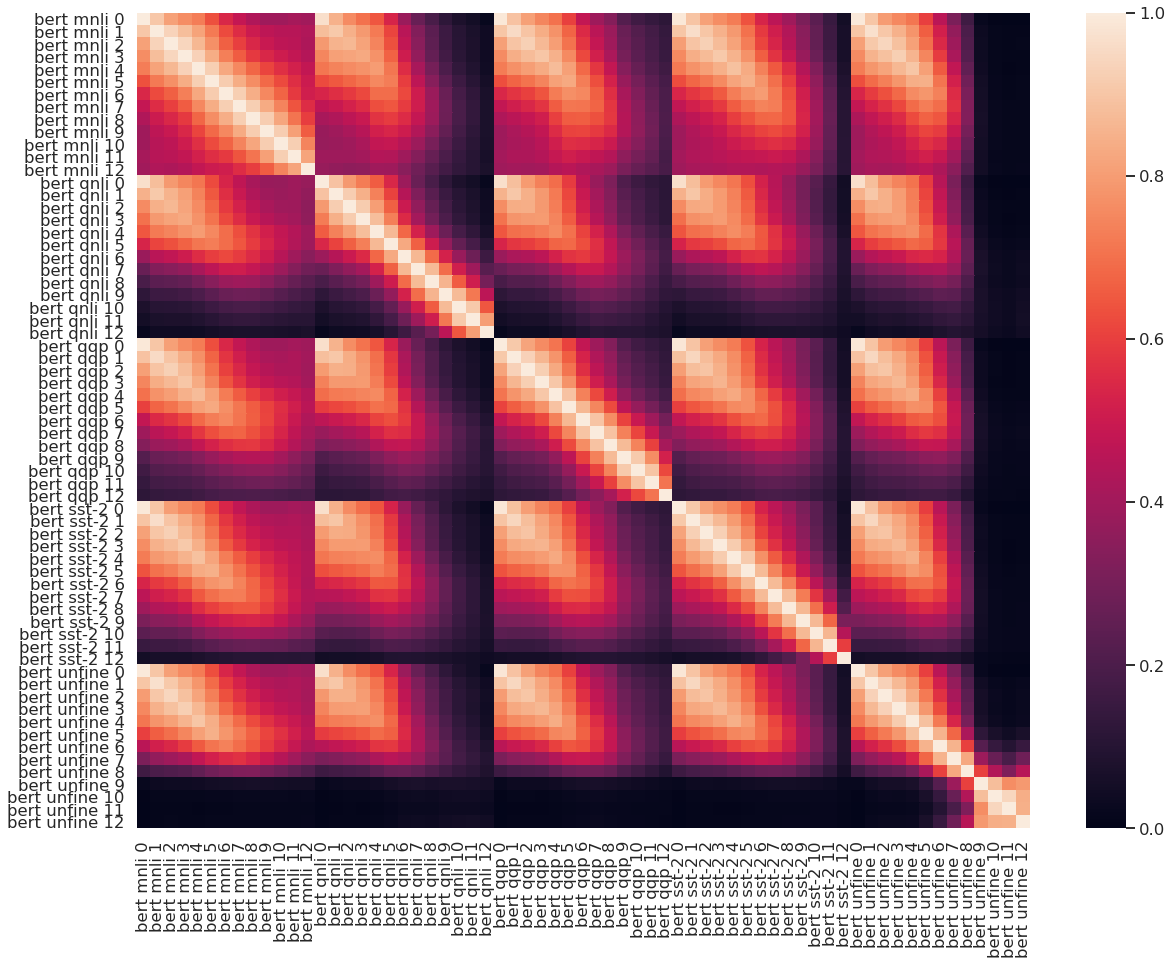

In [22]:
# lincka
g = sns.heatmap(lincka_df.fillna(1), vmin=0, vmax=1, xticklabels=short_labels, yticklabels=short_labels)
g.get_figure().savefig('bert-lincka-heatmap-finetuned.pdf')

In [23]:
def corrs_update(fl, corr_df, fname_prefix, weights_df=None):
    fname = "{0}{1:.2f}.png".format(fname_prefix, fl)
    try:
        im = plt.imread(fname)
        plt.imshow(im)
    except:
        if weights_df is None: # eg. svcca, don't need to do special division
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else 
                                              t[:int(fl*len(t))].mean())
        else:
            denominator_df = weights_df.applymap(lambda t: float('nan') if type(t) is float else 
                                                             t[:int(fl*len(t))].sum())
            df = corr_df.applymap(lambda t: float('nan') if type(t) is float else
                                            t[:int(fl*len(t))].sum())
            df /= denominator_df
        sns.heatmap(df.fillna(1), vmin=0, vmax=1)
        # sns.heatmap(df.fillna(1), )
        plt.savefig(fname, transparent=True)
        plt.show()

In [24]:
# interactive updates
def pw_update(fl):
    corrs_update(fl, pw_corrs_df, "temp_fine_pw1_", weights_df=pw_alignments_df)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(pw_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [25]:
# interactive updates
def sv_update(fl):
    corrs_update(fl, sv_corrs_df, "temp_fine_sv1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(sv_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [26]:
# interactive for maxmincorr
maxmin_corrs = res_d['maxcorr']['corrs']
maxmin_corrs_df = pd.DataFrame(maxmin_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
maxmin_corrs_df = maxmin_corrs_df.reindex(maxmin_corrs_df.columns)
def maxmincorr_update(fl):
    corrs_update(fl, maxmin_corrs_df, "temp_fine_maxmincorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(maxmincorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [27]:
# interactive for linregcorr
linreg_corrs = res_d['maxlinreg']['pred_power']
linreg_corrs_df = pd.DataFrame(linreg_corrs).applymap(lambda a: float('nan') if type(a) is float else -np.sort(-a)) # np sort has no reverse keyword
linreg_corrs_df = linreg_corrs_df.reindex(linreg_corrs_df.columns)
def linregcorr_update(fl):
    corrs_update(fl, linreg_corrs_df, "temp_fine_linregcorr1_", weights_df=None)
slider = FloatSlider(min=0, max=1, step=0.1)
interactive(linregcorr_update, fl=slider)

interactive(children=(FloatSlider(value=0.0, description='fl', max=1.0), Output()), _dom_classes=('widget-inte…

In [28]:
# rbfcka
# sns.heatmap(rbfcka_df.reindex(rbfcka_df.columns).fillna(1), vmin=0, vmax=1)

In [29]:
# # comparing models
# # use lincka
# model1 = "xlnet"
# model2 = "xlnet"
# cols = [s for s in lincka_df.columns if s.find(model1) >= 0]
# rows = [s for s in lincka_df.columns if s.find(model2) >= 0]

In [30]:
# df = lincka_df.loc[rows, cols]

# sns.heatmap(df, xticklabels=range(len(df.columns)), yticklabels=range(len(df.index)), annot=True)
# plt.xlabel(model1)
# plt.ylabel(model2)
# plt.show()

# Localized vs distributed


In [31]:
locl_meth = "maxcorr"
dist_meth = "cca"

# Localized and distributed dataframes
locl_df = pd.DataFrame(res_d[locl_meth]['similarities'])
locl_df = locl_df.reindex(locl_df.columns)

dist_df = pd.DataFrame(res_d[dist_meth]['sv_similarities'])
dist_df = dist_df.reindex(dist_df.columns)

# Localization and distributivity statistics
locl_ser = locl_df.mean(axis=1)
locl_ser = (locl_ser - locl_ser.mean()) / locl_ser.std()

dist_ser = dist_df.mean(axis=1)
dist_ser = (dist_ser - dist_ser.mean()) / dist_ser.std()

# diff_ser
diff_ser = locl_ser - dist_ser

('bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5', 'bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5', 'bert_base_ca

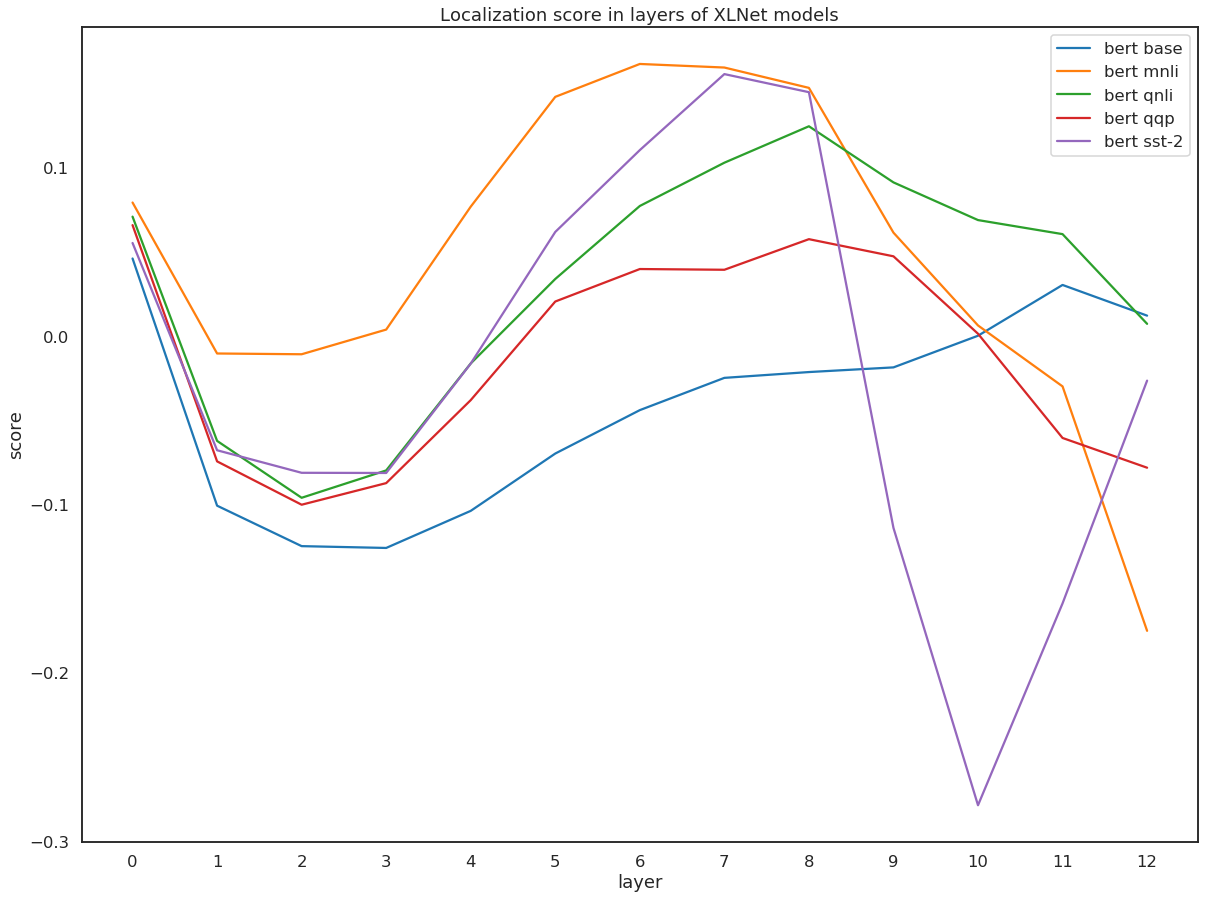

In [36]:
diff_df = pd.DataFrame(diff_ser, columns=['score'])
x = [network_sort_key(layer) for layer in diff_df.index.values]
models, layers = list(zip(*x))
print(models)
models = [model.split('_')[0] + ' ' + model.split('_')[-3] for model in models]
models = ['bert base' if model == 'bert unfine' else model for model in models]
print(models)
print(layers)
diff_df['layer'] = layers
diff_df['model'] = models
diff_df.head()
g = sns.lineplot(data=diff_df, x='layer', y='score', hue='model')
g.set_xticks(range(13))
handles, labels = g.get_legend_handles_labels()
g.legend(handles=handles[1:], labels=labels[1:])
g.set_title('Localization score in layers of XLNet models')
g.get_figure().savefig('bert-loc-score.pdf')

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(diff_ser.sort_values())

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    -0.278417
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -0.174843
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    -0.158553
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_3    -0.125630
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_2    -0.124555
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     -0.113721
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_4    -0.103607
bert_base_cased-ptb_pos_dev_unfine_include_embeddings.hdf5_1    -0.100530
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_2       -0.099958
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_2      -0.095834
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_3       -0.087127
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_3     -0.081105
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_2     -0.081004
bert_base_cased-ptb_pos_dev_qnli_inclu

In [34]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(locl_ser.sort_values())

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    -2.500381
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    -2.444012
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    -2.042827
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -1.985062
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      -1.951866
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11     -1.746926
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10     -1.504538
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     -1.388220
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      -1.379560
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     -1.328486
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9      -1.207550
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11     -1.100358
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_10      -0.944901
bert_base_cased-ptb_pos_dev_unfine_inc

In [35]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): # print everything
    print(dist_ser.sort_values())

bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_12    -2.474110
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_11    -2.285459
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_12      -1.873884
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_12     -1.810218
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_10    -1.764410
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_11     -1.717239
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_10     -1.511041
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_12     -1.395680
bert_base_cased-ptb_pos_dev_qqp_include_embeddings.hdf5_11      -1.319244
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_9      -1.269161
bert_base_cased-ptb_pos_dev_sst-2_include_embeddings.hdf5_9     -1.214765
bert_base_cased-ptb_pos_dev_qnli_include_embeddings.hdf5_11     -1.161090
bert_base_cased-ptb_pos_dev_mnli_include_embeddings.hdf5_8      -0.955497
bert_base_cased-ptb_pos_dev_qqp_includ